In [1]:
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import os 
import psycopg

# load .env contstants
load_dotenv()

connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

# Create a connection string
connection_string = (
    f"postgresql://{postgres_credentials['user']}:{postgres_credentials['password']}"
    f"@{postgres_credentials['host']}:{postgres_credentials['port']}/{postgres_credentials['dbname']}"
)

# Create a SQLAlchemy engine
engine = create_engine(connection_string)


def load(TABLE_NAME):
    connection.update(postgres_credentials)
    with psycopg.connect(**connection) as conn:
        with conn.cursor() as cur:
            cur.execute(f"SELECT * FROM {TABLE_NAME}")
            data = cur.fetchall()
            columns = [col[0] for col in cur.description]
    df = pd.DataFrame(data, columns=columns)

    return df

E-commerce Data Analysis (conclusion from this notebook): 

Events Dynamics

1. Users primarily interact once (75%) and only twice (<20%).
2. The dynamics between views/add-to-cart actions and transactions correlate over time.
3. Weekends show the lowest activity levels.
4. User engagement dynamics exhibit a 1-2 week seasonal pattern.
5. 80% of views are concentrated on the 20% most popular products.
6. Cumulative transactions have a less steep curvature compared to views.
7. All items properties reviewed at 3am in morning 

Items Properties

The first 20 most common properties are present on the majority of products. 
However, properties ranked lower than 20 account for a small fraction of goods.

1. Two properties were constants.
2. Several properties were of text type; these will be addressed later.
3. The 8th feature (property 790) appears to represent price, making it the best candidate among others in the top 15, based on sensible value distribution.
4. There are 1,200 unique item IDs and 300 categories.
5. The feature "available" is present, which is important.
6. On average, 25 properties are used to describe a product.


Features to add to the model from EDA discovery:

1. Price 
2. TI-DF+SVD(product paragraph text description) (future granual recomend)
3. Seasonalities 
4. Parent category as label encode (300 of them)
5. Frequency encode categories 


Modelling:

1. Very low user - item interaction -> recomend categories, not individual items
2. ParentID is too small, can lead to exclusion of electronics 
3. On the hand categories will remove TV's, but not electronics


1. Events EDA 

In [2]:
events = load("events")
events.head(5)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [3]:
# time format must be cahnged 
events["timestamp"] = pd.to_datetime(events['timestamp'], unit='ms')
events.set_index('timestamp', inplace=True)

In [4]:
# look for nans
events.isna().sum(),len(events)

(visitorid              0
 event                  0
 itemid                 0
 transactionid    2733644
 dtype: int64,
 2756101)

In [5]:
events[events["transactionid"].notna()]

,visitorid,event,itemid,transactionid
timestamp,,,,
2015-06-02 05:17:56.276,599528,transaction,356475,4000.0
2015-06-01 21:18:20.981,121688,transaction,15335,11117.0
2015-06-01 21:25:15.008,552148,transaction,81345,5444.0
2015-06-01 16:38:56.375,102019,transaction,150318,13556.0
2015-06-01 16:01:58.180,189384,transaction,310791,7244.0
...,...,...,...,...
2015-07-31 21:12:56.570,1050575,transaction,31640,8354.0
2015-07-31 21:57:58.779,861299,transaction,456602,3643.0
2015-07-31 15:48:50.123,855941,transaction,235771,4385.0


In [6]:
# what do non na transaction mean in terms of the event type  
events[events["transactionid"].notna()]["event"].value_counts()

event
transaction    22457
Name: count, dtype: int64

#### Transaction id is not none when people made purchase 

In [7]:
# what are the events start and end dates 
events.index.min(), events.index.max()

(Timestamp('2015-05-03 03:00:04.384000'),
 Timestamp('2015-09-18 02:59:47.788000'))

In [8]:
# duplicates reasons 
events[events[["visitorid","event","itemid"]].duplicated()]["event"].value_counts()

event
view           532185
addtocart        7307
transaction      1187
Name: count, dtype: int64

In [9]:
# what is the fraction of the duplicated events  
(532185+7307+1187)/len(events)

0.19617532158654563

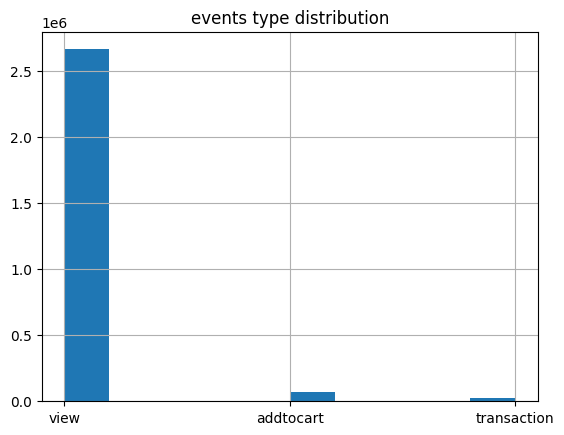

In [10]:
import matplotlib.pyplot as plt 
events["event"].hist()   
plt.title("events type distribution")
plt.savefig("../mlflow_server/assets/events_distribution.jpg")
plt.show()

#### As expected the views are the majour source of the events 

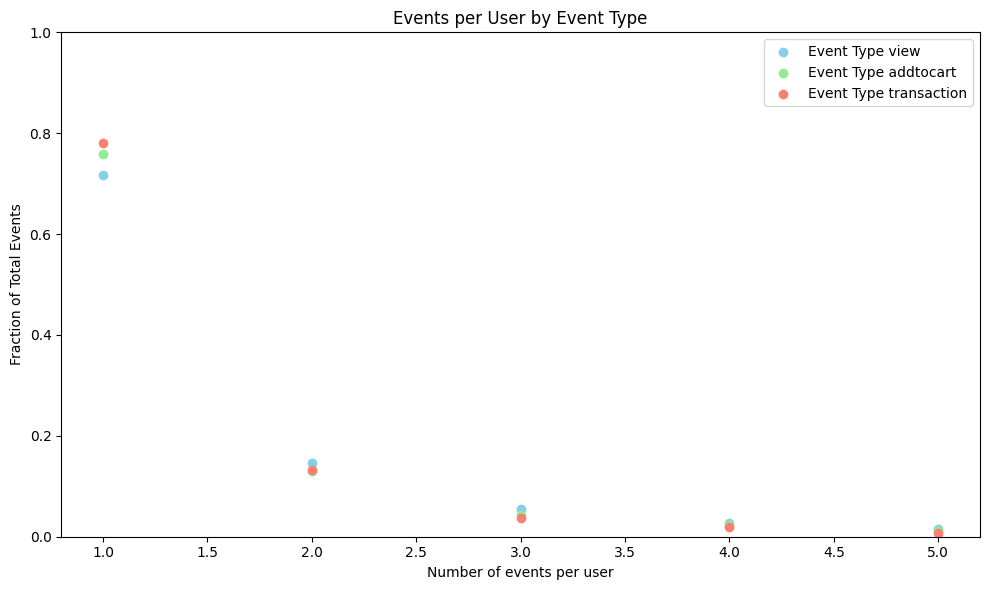

In [12]:
# Define event types to analyze
event_types = events['event'].unique()

colors = ['skyblue', 'lightgreen', 'salmon']

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each event type and plot on the same axes
for i, event_type in enumerate(event_types):
    # Filter events for the specific event type
    df_transactions = events[events["event"] == event_type]
    
    # Count transactions by visitor ID and calculate transaction counts
    transaction_counts = df_transactions.groupby("visitorid").agg("count").reset_index()["itemid"].value_counts()

    # Calculate fractions
    transaction_fractions = transaction_counts.values / transaction_counts.sum()

    # Scatter plot, assign a unique color to each event type
    ax.scatter(transaction_counts.index[:5], transaction_fractions[:5], color=colors[i], label=f'Event Type {event_type}')

# Add titles, labels, and legend
ax.set_title('Events per User by Event Type')
ax.set_xlabel('Number of events per user')
ax.set_ylabel('Fraction of Total Events')
ax.set_ylim(0, 1)  # Set y-axis limits for better visualization
ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("../mlflow_server/assets/events_per_user_combined.jpg")
plt.show()

#### On average every user makes 75% of interactions once and less than 20% twice 

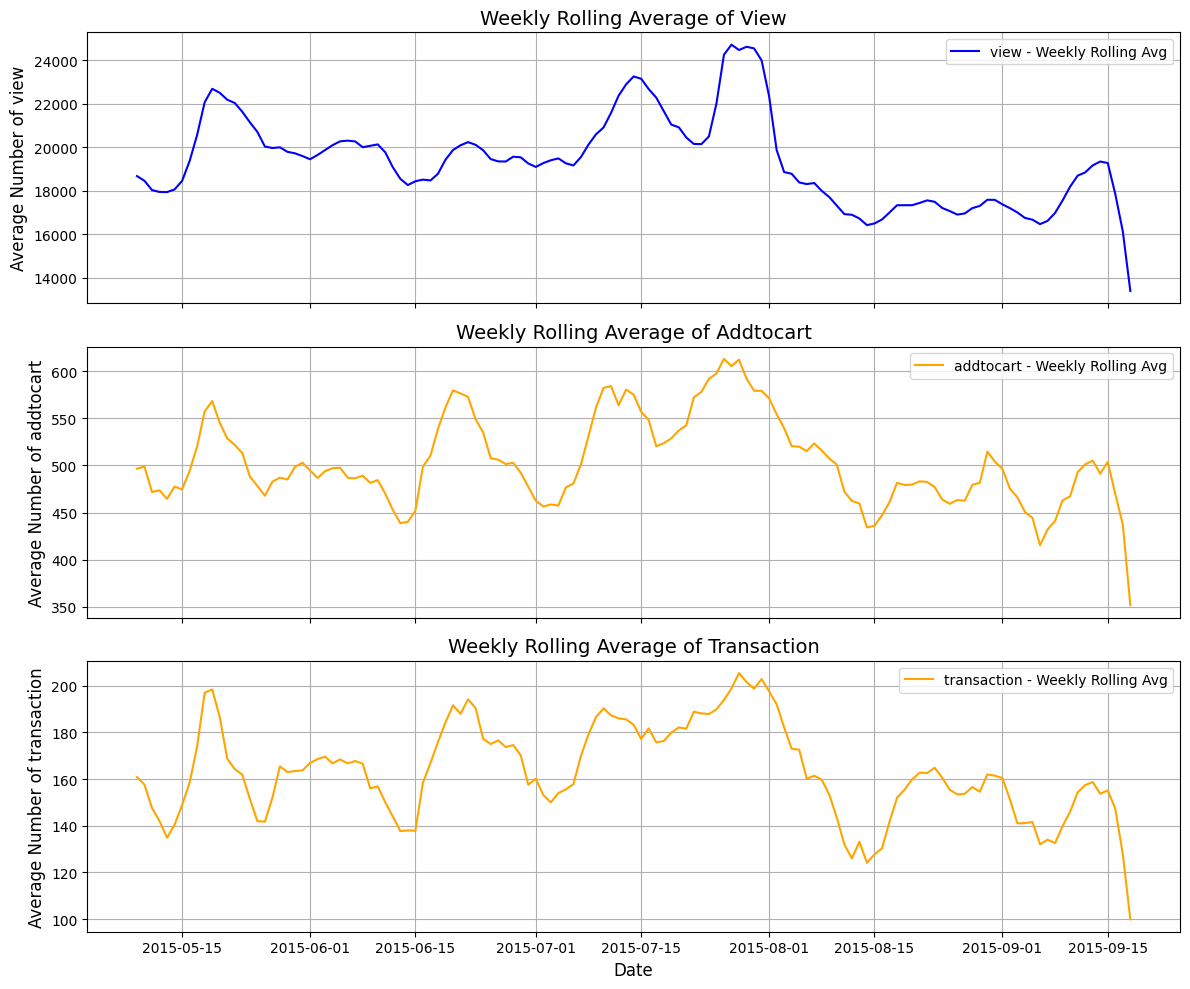

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)

event_types = ["view", 'addtocart', 'transaction']

# Iterate through each event type and plot the weekly rolling average
for i, event_type in enumerate(event_types):
    # Filter the DataFrame for the current event type
    group = events[events['event'] == event_type]
    
    # Resample to daily frequency and count the number of events per day
    daily_event_count = group.resample('D').size()
    
    # Calculate the weekly rolling average
    weekly_rolling_avg = daily_event_count.rolling(window=7).mean()
    
    # Plot the weekly rolling average in the corresponding subplot
    axs[i].plot(weekly_rolling_avg, label=f'{event_type} - Weekly Rolling Avg', color='blue' if event_type == 'view' else 'orange')
    axs[i].set_title(f'Weekly Rolling Average of {event_type.capitalize()}', fontsize=14)
    axs[i].set_ylabel('Average Number of'+' ' + f'{event_type}', fontsize=12)
    axs[i].legend()
    axs[i].grid(True)

# Set common x-label for the bottom subplot
axs[2].set_xlabel('Date', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig("../mlflow_server/assets/user_activity_time_trend.jpg")
plt.show()


#### Views, addtochart and sales correlate with each other 
#### One and two weeks seasonalities are present 

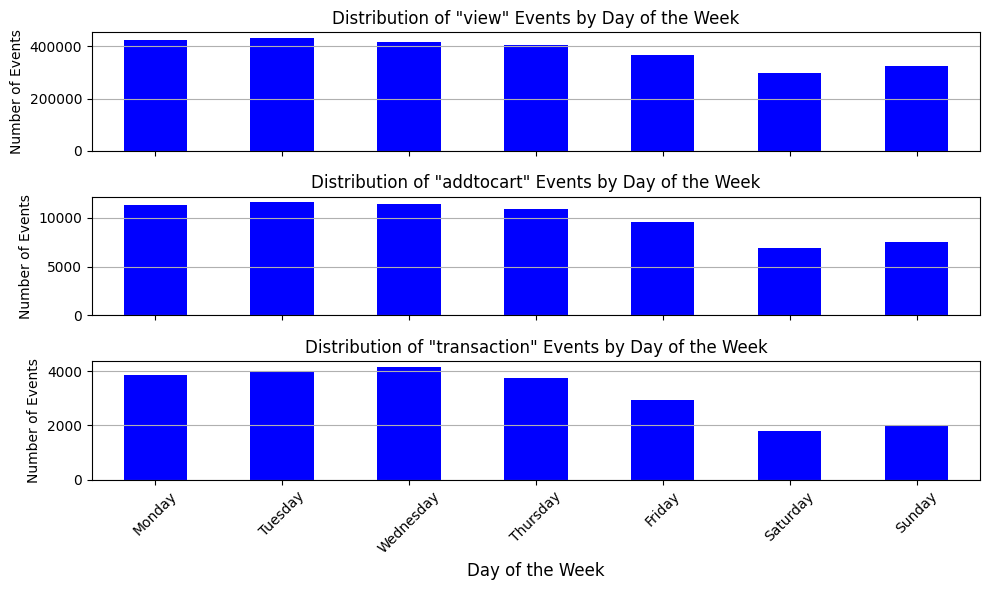

In [14]:
# Extract day of the week from the index
events['day_of_week'] = events.index.day_name()

# Create subplots for each event type
event_types = events['event'].unique()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axes = plt.subplots(len(event_types), 1, figsize=(10, 6), sharex=True)

# Count occurrences of each event type by day of the week and plot
for ax, event in zip(axes, event_types):
    event_data = events[events['event'] == event]
    event_counts = event_data['day_of_week'].value_counts().reindex(days_order)
    event_counts.plot(kind='bar', ax=ax, color='blue')
    ax.set_title(f'Distribution of "{event}" Events by Day of the Week', fontsize=12)
    ax.set_ylabel('Number of Events', fontsize=10)
    ax.grid(axis='y')

# Set common x-label
plt.xlabel('Day of the Week', fontsize=12)
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.savefig("../mlflow_server/assets/event_distribution_by_day_of_week_subplots.jpg", bbox_inches='tight')
plt.show()

#### User's activities reduce the most during weekends. 
#### Transactions volume drops almost twice 

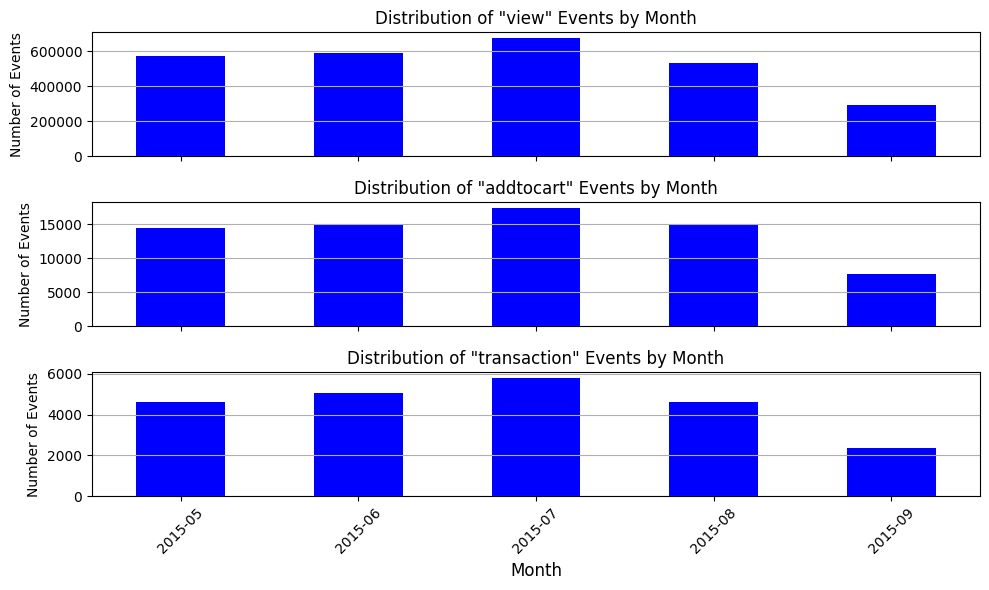

In [15]:
# Create a 'month' column for grouping
events['month'] = events.index.to_period('M')

# Create subplots for each event type
event_types = events['event'].unique()
fig, axes = plt.subplots(len(event_types), 1, figsize=(10, 6), sharex=True)

# Count occurrences of each event type by month and plot
for ax, event in zip(axes, event_types):
    event_data = events[events['event'] == event]
    event_counts = event_data['month'].value_counts().sort_index()
    event_counts.plot(kind='bar', ax=ax, color='blue')
    ax.set_title(f'Distribution of "{event}" Events by Month', fontsize=12)
    ax.set_ylabel('Number of Events', fontsize=10)
    ax.grid(axis='y')

# Set common x-label
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.savefig("../mlflow_server/assets/event_distribution_by_month_subplots.jpg", bbox_inches='tight')
plt.show()

#### Monthly volumes are relatively stable
#### September shows the least value, becouse the dataset finishes on 18th of September 

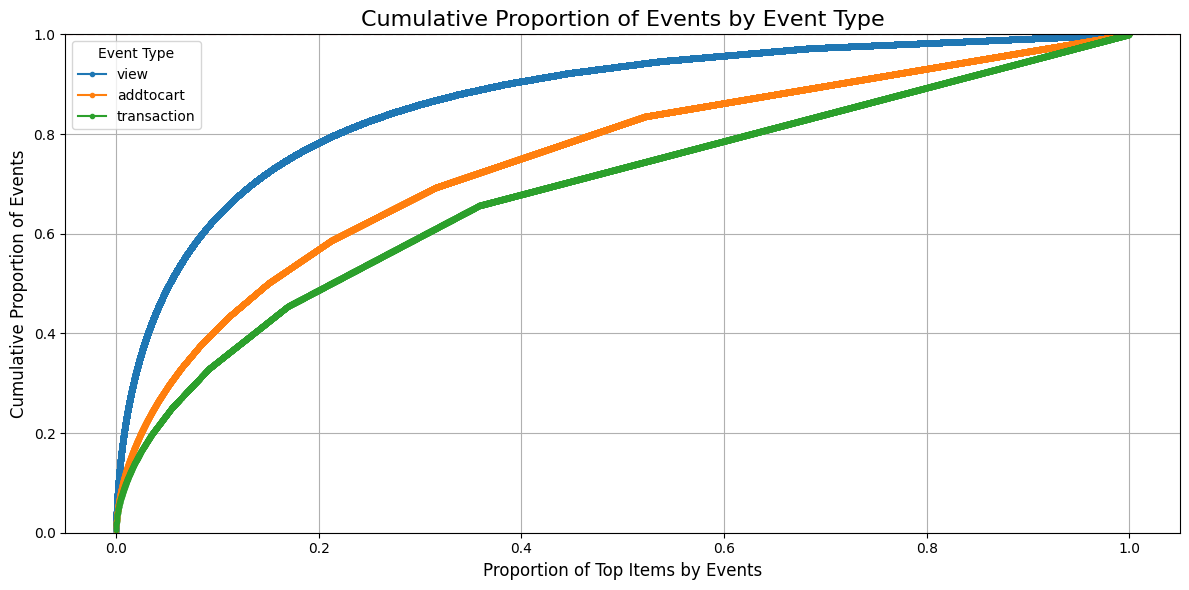

In [16]:
event_types = events['event'].unique()
dfs = {}

# Loop through each event type to calculate item counts and cumulative proportions
for event in event_types:
    item_counts = events[events['event'] == event]["itemid"].value_counts()
    df_item_counts = pd.DataFrame(item_counts.items(), columns=['itemid', 'count'])
    
    # Calculate total sales for the event
    total_sales = df_item_counts['count'].sum()

    # Sort values to identify top sold items
    df_item_counts = df_item_counts.sort_values('count', ascending=False)

    # Calculate cumulative sales and proportion
    df_item_counts['cumulative_sales'] = df_item_counts['count'].cumsum()
    df_item_counts['proportion'] = df_item_counts['cumulative_sales'] / total_sales
    
    # Create an index for the number of top sold items
    df_item_counts.loc[:, 'item_number'] = range(1, len(df_item_counts) + 1)
    
    # Store the DataFrame for each event type
    dfs[event] = df_item_counts

# Plot
plt.figure(figsize=(12, 6))

# Plot for each event type
for event, df_top_k in dfs.items():
    plt.plot(df_top_k['item_number'] / df_top_k['item_number'].max(), df_top_k['proportion'], marker='.', linestyle='-', label=event)

# Customize the plot
plt.title('Cumulative Proportion of Events by Event Type', fontsize=16)
plt.xlabel('Proportion of Top Items by Events', fontsize=12)
plt.ylabel('Cumulative Proportion of Events', fontsize=12)
plt.ylim(0, 1)  # Ensure the y-axis goes from 0 to 1
plt.grid()
plt.axhline(y=1, color='r', linestyle='--')  # Optional line at y=1 for reference
plt.legend(title='Event Type')  # Add a legend for event types
plt.tight_layout()

# Save the plot if needed
plt.savefig("../mlflow_server/assets/top_k_items_cumulative_proportion_by_event_type.jpg", bbox_inches='tight')

plt.show()

#### 20% of the most popular items contribute to the 80% of the views
#### The relationship is less steap for transactions (views do not contribute to transactions alone)
#### Factors such as pricing might impact view to transaction convertion

In [17]:
del events

item_properties

In [18]:
item_properties_part1 = load("item_properties_part1")
item_properties_part2 = load("item_properties_part2")

In [19]:
# time range in item_properties dataset 
item_properties_part1["timestamp"] =  pd.to_datetime(item_properties_part1['timestamp'], unit='ms')
item_properties_part2["timestamp"] =  pd.to_datetime(item_properties_part2['timestamp'], unit='ms')

print(item_properties_part1["timestamp"].min(),item_properties_part1["timestamp"].max(),item_properties_part2["timestamp"].min(),item_properties_part2["timestamp"].max())

# reset index for timeseries manipulations
item_properties_part1.set_index("timestamp")
item_properties_part2.set_index("timestamp")

2015-05-10 03:00:00 2015-09-13 03:00:00 2015-05-10 03:00:00 2015-09-13 03:00:00


,itemid,property,value
timestamp,,,
2015-05-31 03:00:00,183478,561,769062
2015-08-16 03:00:00,132256,976,n26.400 1135780
2015-06-28 03:00:00,420307,921,1149317 1257525
2015-05-17 03:00:00,403324,917,1204143
2015-06-28 03:00:00,230701,521,769062
...,...,...,...
2015-06-07 03:00:00,236931,929,n12.000
2015-08-30 03:00:00,455746,6,150169 639134
2015-08-16 03:00:00,347565,686,610834


#### The range of times for the properties dataset is almost the same as events

In [20]:
item_properties_part1["timestamp"].dt.hour.value_counts(),item_properties_part2["timestamp"].dt.hour.value_counts()

(timestamp
 3    10999999
 Name: count, dtype: int64,
 timestamp
 3    9275903
 Name: count, dtype: int64)

#### Important observation ! Goods properties get assigned at 3am in the morning 

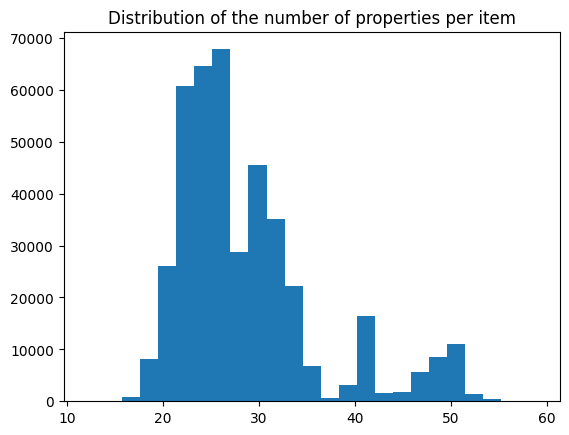

In [21]:
import seaborn as sns

df_prop = pd.concat([item_properties_part1,item_properties_part2])
items_properties = df_prop[~df_prop[["itemid","property"]].duplicated()][["itemid","property"]]
property_per_item_count = items_properties.groupby("itemid").agg("count").reset_index()
plt.hist(property_per_item_count["property"],bins=25)
plt.title("Distribution of the number of properties per item")
plt.savefig("../mlflow_server/assets/properties_per_item.jpg", bbox_inches='tight')
plt.show()

#### Goods description showes 3 modes: first includes 25 properties, the second about 40 and the last is 50

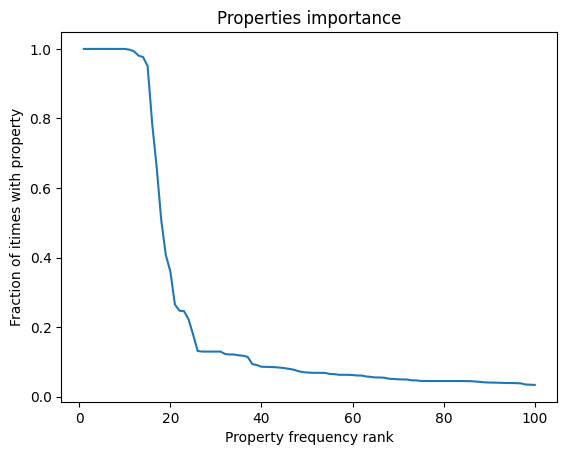

In [22]:
property_count = df_prop[~df_prop[["itemid","property"]].duplicated()].groupby("property").agg("count").sort_values("value",ascending=False).reset_index()[["property","value"]]
n_unique_items = len(df_prop[~df_prop[["itemid","property"]].duplicated()]["itemid"].unique())
property_count["value"] = property_count["value"]/n_unique_items
plt.plot(list(range(1, 101)), property_count["value"].iloc[:100])
plt.xlabel("Property frequency rank")
plt.ylabel("Fraction of itimes with property")
plt.title("Properties importance")
plt.savefig("../mlflow_server/assets/properties_importance.jpg", bbox_inches='tight')
plt.show()

In [23]:
print("the total number of unique properties count = {}".format(len(property_count)))

the total number of unique properties count = 1104


In [25]:
# print 25 most common properties
property_count.head(25)

,property,value
0,159,1.000000
1,283,1.000000
2,categoryid,1.000000
3,available,1.000000
4,112,1.000000
5,888,1.000000
6,764,1.000000
7,790,1.000000
8,364,1.000000
9,678,0.999918


In [26]:
top_15_properties = property_count["property"].loc[:14]
# Saving to a txt file
file_path = '../mlflow_server/assets/top_15_properties.txt'
with open(file_path, 'w') as file:
    for property in top_15_properties:
        file.write(f"{property}\n")

#### 1. Observation: First 15 properties are present in almost all goods, than there is steep fall at 25 to about 15% of items
#### 2. Conclusion: for the first model iteration I will prioritise processing and investigating the first 15 properties
#### 3. The rest will be investigated later

# Properties distributions 

### 1 / 15 prop's

In [27]:
# The first of the top 15 properties is a constant, meaning it will not be included in the modelling 
df_prop[df_prop["property"] == top_15_properties[0]]["value"].value_counts()

value
519769    417053
Name: count, dtype: int64

### 2 /15 prop's

In [28]:
df_prop[df_prop["property"] == top_15_properties[1]]["value"]

158                                     132734 242183 797785
175                                    1319279 920988 639039
309                                     554317 820477 938947
334                            882006 768453 1113872 1230005
338        341599 912235 363182 695707 479886 341599 9122...
                                 ...                        
9275765       971154 292676 1318713 864089 215470 n13872.000
9275782                  305351 322391 1120576 114320 221130
9275805    188678 1128577 227976 309875 486553 n48.000 31...
9275830                   598729 511183 981281 829153 631983
9275860    132734 718335 820527 73763 132734 1148760 8205...
Name: value, Length: 597419, dtype: object

Text(0, 0.5, 'Frequency in the dataset')

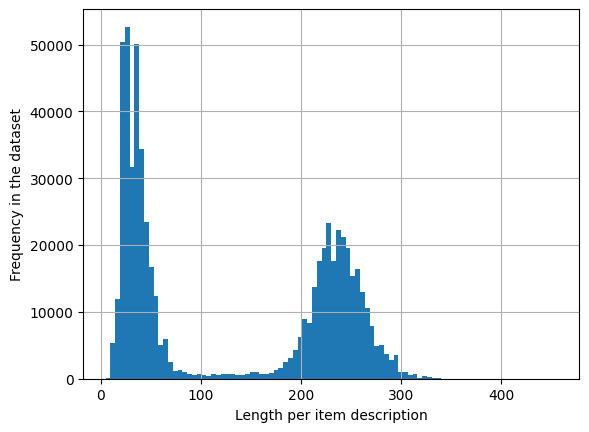

In [29]:
df_prop[df_prop["property"] == top_15_properties[1]]["value"].apply(lambda x:len(x)).hist(bins="auto")
plt.xlabel("Length per item description")
plt.ylabel("Frequency in the dataset")

In [30]:
df_prop[df_prop["property"] == top_15_properties[1]]["value"].dtype

dtype('O')

Small investigation of the potential text corpus 

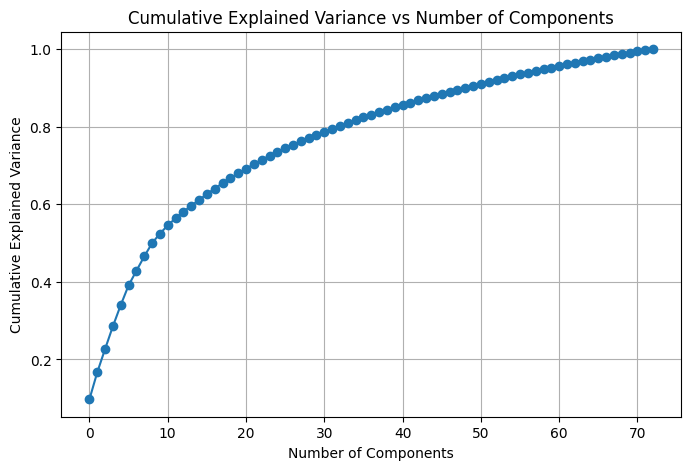

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Sample data as a Pandas Series
data = df_prop[df_prop["property"] == top_15_properties[1]]["value"]

vectorizer = TfidfVectorizer(min_df=500, # Min doc frequency to remove rare words for this dataset will be 0.01% of docs 
                             max_df=0.8, # Remove too common words
                             max_features=50000, # max features to build 
                             token_pattern=r'(?u)\b\w*[a-zA-Z]\w*\b') # exclude numeric values

X_tfidf = vectorizer.fit_transform(data.values)
svd = TruncatedSVD(n_components=X_tfidf.shape[1])  # Choose a high number of components
X_reduced = svd.fit_transform(X_tfidf)

# Get the explained variance ratio for each component
explained_variance = svd.explained_variance_ratio_

# Calculate the cumulative sum of explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

#### Strong indication that this property is an encoded text description.

1. The lengths of the two modes per row are similar to the word count of small paragraphs.
2. The data includes integer entries formatted like \n48.000, while the rest do not have decimals and are all integers.
3. The data is stored as dtype('O') in pandas, which is a common way to save strings.
4. TF-IDF and dimensionality reduction will be used as the first method to vectorize the encoded text description.
5. (Trade-off between speed (1) and accuracy (2): [1: (30 components, 80% variance)] while [2: (55 components, 90% variance)]).

### 3/15 prop's

In [68]:
# this property has physical meaning, which is a kind of product
df_prop[df_prop["property"] == top_15_properties[2]].head(5)

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
140,2015-05-24 03:00:00,281245,categoryid,1277
151,2015-06-28 03:00:00,35575,categoryid,1059
189,2015-07-19 03:00:00,8313,categoryid,1147
197,2015-07-26 03:00:00,55102,categoryid,47


In [69]:
category_tree = load("category_tree")
filtered_df = df_prop[df_prop["property"] == top_15_properties[2]]
filtered_df['value'] = filtered_df['value'].astype(int)  # Convert value to int

merged_df = filtered_df.merge(category_tree, how="left", left_on="value", right_on="categoryid")


/tmp/ipykernel_1931/2909747104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['value'] = filtered_df['value'].astype(int)  # Convert value to int


In [71]:
# parents ids have much smaller cardinality compared to categories ids
len(merged_df["parentid"].unique()), len(filtered_df["value"].unique())

(305, 1242)

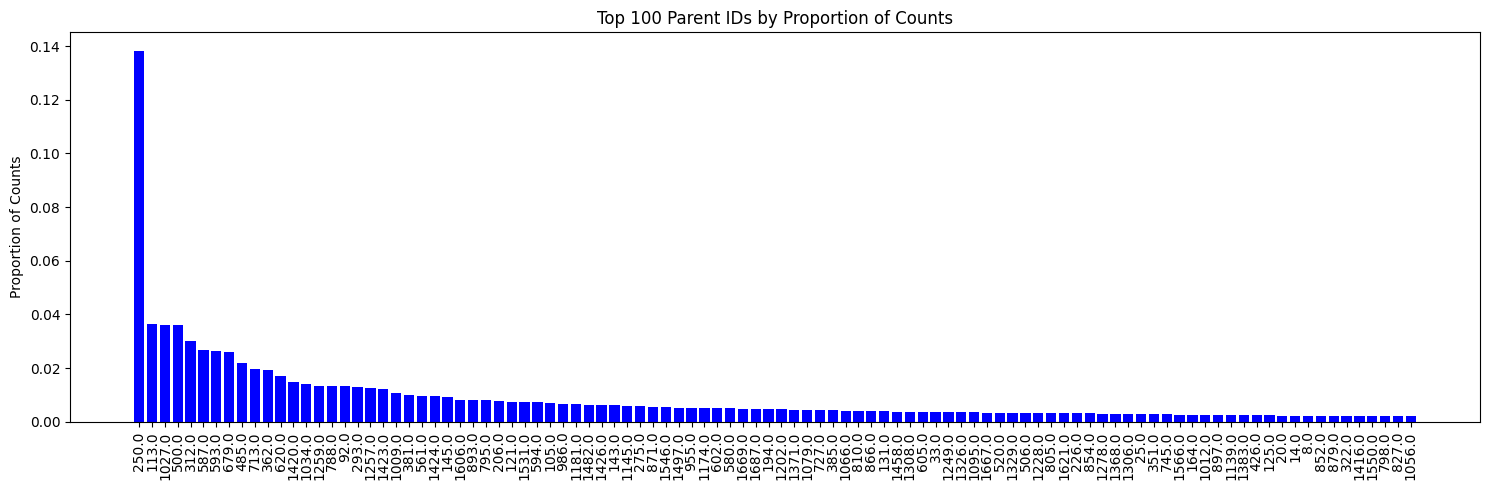

In [72]:
# Group by 'parentid', count occurrences, and sort by count in descending order
sorted_df = merged_df.groupby("parentid").agg("count").reset_index()
sorted_df = sorted_df.sort_values("value", ascending=False)

# Calculate the proportion of counts relative to the total number of item IDs
sorted_df["value"] = sorted_df["value"] / len(merged_df["itemid"])

# Limit to the top 50 parent IDs
top_sorted_df = sorted_df.head(100)

# Create the bar plot
plt.figure(figsize=(15, 5))  # Set the figure size
plt.bar(top_sorted_df["parentid"].astype(str), top_sorted_df["value"], color='blue')  # Use parentid as x and value as y
plt.ylabel('Proportion of Counts')  # Label for y-axis
plt.title('Top 100 Parent IDs by Proportion of Counts')  # Title of the plot
plt.xticks(rotation=90)  # Rotate x-ticks for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot

#### Observation: almost uniform distribution after top 8 parents ids by frequency fraction in dataset, therefore frequency encoding for parents IDs is not suitable
#### Conclusion: since i will use tree based models, simple label encoding of parents IDs will be used as the first method 

### 4/15 prop's 

In [73]:
filtered_df = df_prop[df_prop["property"] == top_15_properties[3]]

In [74]:
# this property is binary 0/1 not available/available -> one-hot encode
filtered_df

,timestamp,itemid,property,value
5,2015-07-05 03:00:00,285026,available,0
15,2015-07-19 03:00:00,186518,available,0
79,2015-06-07 03:00:00,423682,available,0
82,2015-06-14 03:00:00,316253,available,1
96,2015-07-19 03:00:00,430459,available,0
...,...,...,...,...
9275846,2015-08-30 03:00:00,229797,available,0
9275856,2015-08-02 03:00:00,225378,available,1
9275890,2015-05-31 03:00:00,356167,available,0
9275892,2015-08-09 03:00:00,200211,available,0


### 5/15 prop's

In [75]:
filtered_df = df_prop[df_prop["property"] == top_15_properties[4]]

In [76]:
# This is a constant property -> exclude from modelling 
filtered_df["value"].value_counts()

value
679677    417053
Name: count, dtype: int64

### 6/15 prop's

In [77]:
filtered_df = df_prop[df_prop["property"] == top_15_properties[5]]

In [78]:
filtered_df.head(5)

,timestamp,itemid,property,value
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
10,2015-08-09 03:00:00,450113,888,1038400 45956 n504.000
17,2015-07-12 03:00:00,319291,888,1292080
26,2015-06-28 03:00:00,16615,888,150169 176547 824301 24474 293011 1240134
40,2015-06-07 03:00:00,152892,888,599031


Text(0, 0.5, 'Frequency in the dataset')

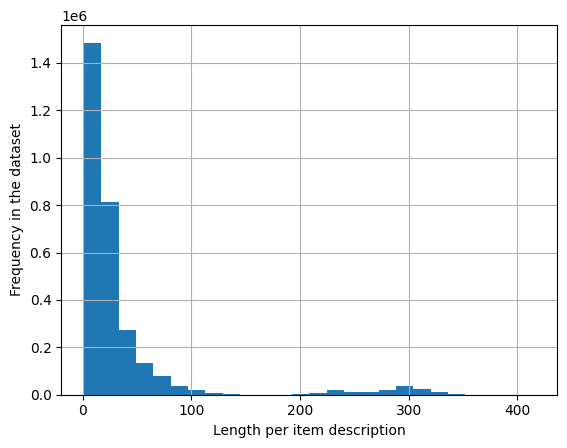

In [79]:
filtered_df["value"].apply(lambda x:len(x)).hist(bins=26)
plt.xlabel("Length per item description")
plt.ylabel("Frequency in the dataset")

#### This is enother text encoded feature 

### 7/15 prop's

In [80]:
# constant -> remove
filtered_df = df_prop[df_prop["property"] == top_15_properties[6]]
filtered_df["value"].value_counts()

value
1285872    417053
Name: count, dtype: int64

### 8/15 prop's

In [81]:
filtered_df = df_prop[df_prop["property"] == top_15_properties[7]]
filtered_df.head(5)

,timestamp,itemid,property,value
3,2015-05-10 03:00:00,59481,790,n15360.000
14,2015-06-14 03:00:00,169055,790,n21000.000
16,2015-06-28 03:00:00,178601,790,n5400.000
42,2015-05-17 03:00:00,125874,790,n39588.000
46,2015-06-07 03:00:00,272201,790,n10320.000


In [85]:
# looks like a single entety wich is present in all goods, could be either:
# a) word 
# b) price
is_single_string = filtered_df["value"].apply(lambda x: isinstance(x, str) and len(x) > 0)
import numpy as np
np.all(is_single_string)

True

In [82]:
def is_likely_price(value):
    if pd.to_numeric(value.replace('n', ''), errors='coerce') is not None:
        return True  # It could be a price
    else:
        return False  # It is more likely a word

In [84]:
import numpy as np
filtered_df['is_price'] = filtered_df['value'].apply(is_likely_price)
np.all(filtered_df["is_price"])

/tmp/ipykernel_1931/2214672023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['is_price'] = filtered_df['value'].apply(is_likely_price)


True

/tmp/ipykernel_1931/6288203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['numeric_value'] = filtered_df['value'].str.extract(r'(\d+\.\d+)').astype(float)


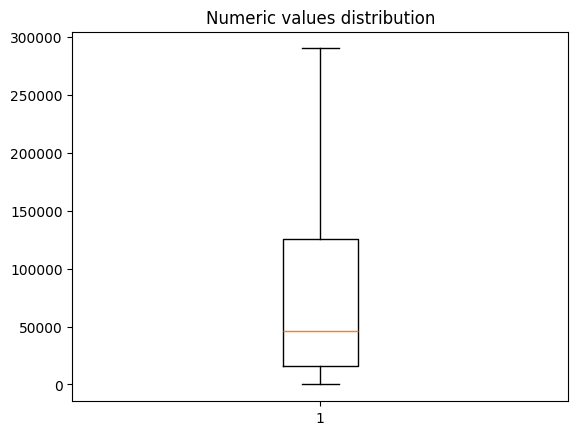

In [85]:
# Distribution might indicate if the price numbers are unreal
filtered_df['numeric_value'] = filtered_df['value'].str.extract(r'(\d+\.\d+)').astype(float)
plt.boxplot(filtered_df['numeric_value'].values,showfliers=False)
plt.title("Numeric values distribution")
plt.show()

In [86]:
len(filtered_df['numeric_value'].unique())/len(filtered_df)

0.018459483188086562

#### This column could represents either single word or price (based on numbers distribution and ease of convertion). Numeric range is ok for RUB prices

### 9/15 prop's

In [87]:
filtered_df = df_prop[df_prop["property"] == top_15_properties[8]]

In [88]:
# cardinality check
len(filtered_df["value"].unique())/len(filtered_df)

0.8826156487283991

In [89]:
# median calculation
filtered_df["value"] = filtered_df["value"].astype(int)
np.median(filtered_df["value"].values)

/tmp/ipykernel_1931/4007536083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["value"] = filtered_df["value"].astype(int)


668900.0

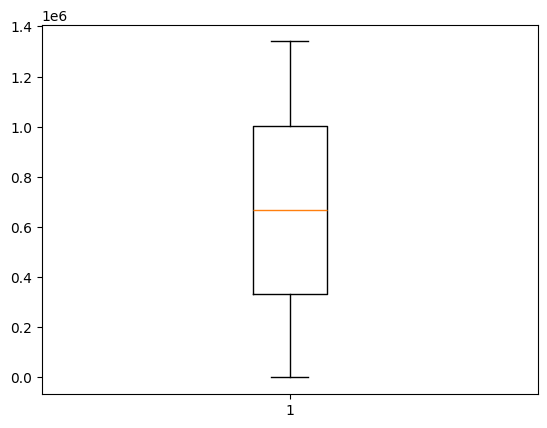

In [90]:
plt.boxplot(filtered_df['value'].values,showfliers=False)
plt.show()

In [94]:
didgit_length = [len(str(x)) for x in filtered_df['value'].values]

In [97]:
np.unique(np.array(didgit_length), return_counts=True)


(array([1, 2, 3, 4, 5, 6, 7]),
 array([     3,     33,    295,   3287,  32042, 320112, 120714]))

1. This feature is not a price for sure, eventhough it was stored without /n, becouse the median value is too high 
2. The feature has high variety in dataset, could be an index 1-7 didgit length
3. Not sure what to do with it in modelling, for now exclude it

### 10/15 prop's

In [98]:
filtered_df = df_prop[df_prop["property"] == top_15_properties[9]]

In [103]:
filtered_df.head(15)

,timestamp,itemid,property,value
85,2015-06-28 03:00:00,197829,678,662492
284,2015-07-12 03:00:00,122410,678,922011 840490
347,2015-08-30 03:00:00,42853,678,367680
430,2015-06-28 03:00:00,71952,678,286484
431,2015-06-28 03:00:00,117686,678,34806 753764
432,2015-05-10 03:00:00,76889,678,833538
435,2015-05-10 03:00:00,114241,678,634144
477,2015-05-10 03:00:00,210462,678,682142
556,2015-06-28 03:00:00,90386,678,475657
561,2015-05-10 03:00:00,397786,678,820477


In [101]:
filtered_df["value"].apply(lambda x: len(x)).value_counts()

value
6     256321
7     106733
13     53202
14     25465
5      20829
12      4919
19      3483
15      2878
4       2325
23      2259
21      1667
20      1043
28       337
11       212
22       148
16        75
18        37
35        26
27         7
Name: count, dtype: int64

### 11/15 prop's

In [104]:
filtered_df = df_prop[df_prop["property"] == top_15_properties[10]]

In [105]:
filtered_df.head(5)

,timestamp,itemid,property,value
4,2015-05-17 03:00:00,156781,917,828513
51,2015-05-17 03:00:00,299516,917,1000352 624695
80,2015-06-07 03:00:00,360984,917,300207
84,2015-06-07 03:00:00,116504,917,n1923864.000 1197088
88,2015-05-17 03:00:00,174204,917,1068301


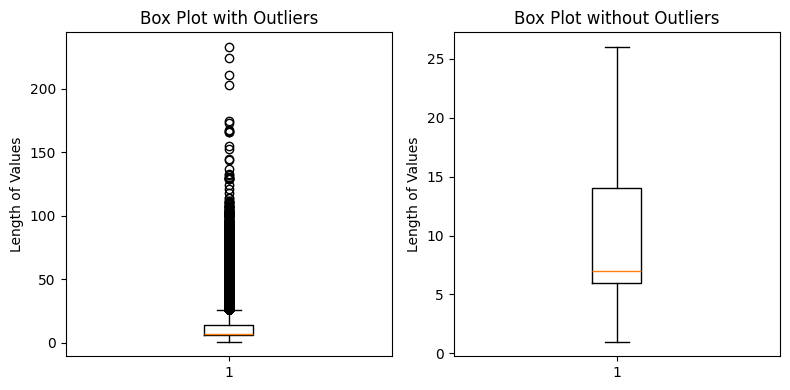

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# First box plot showing all data
axs[0].boxplot(filtered_df["value"].apply(lambda x: len(x)))
axs[0].set_title('Box Plot with Outliers')
axs[0].set_ylabel('Length of Values')

# Second box plot hiding outliers
axs[1].boxplot(filtered_df["value"].apply(lambda x: len(x)), showfliers=False)
axs[1].set_title('Box Plot without Outliers')
axs[1].set_ylabel('Length of Values')

# Adjust layout
plt.tight_layout()
plt.show()

#### Again a short text encoded description 

### 12/15 prop's 

In [107]:
filtered_df = df_prop[df_prop["property"] == top_15_properties[11]]

In [108]:
filtered_df.head(5)

,timestamp,itemid,property,value
8,2015-06-07 03:00:00,229370,202,1330310
34,2015-08-16 03:00:00,460970,202,949574
108,2015-06-07 03:00:00,382111,202,983069
111,2015-06-28 03:00:00,47890,202,n114420.000 855272
117,2015-06-28 03:00:00,4549,202,823500


In [109]:
unique_values = filtered_df['value'].unique()
print("Unique values in 'value' column:")
print(unique_values)

# Step 2: Check which values can be converted to numeric
# Function to identify non-numeric values
def check_numeric_conversion(value):
    try:
        # Try converting to float; if it fails, return False
        float(value)  # Using float to catch both int and float formats
        return True
    except ValueError:
        return False

# Apply the function to the 'value' column
can_convert = filtered_df['value'].apply(lambda x: all(check_numeric_conversion(v) for v in str(x).replace('n', '').split()))
non_numeric_values = filtered_df[~can_convert]

Unique values in 'value' column:
['1330310' '949574' '983069' ... '1311440' '1205869' '734857']


In [110]:
print("\nRows with non-numeric values in 'value' column:")
print(non_numeric_values)


Rows with non-numeric values in 'value' column:
                  timestamp  itemid property                     value
25777   2015-06-28 03:00:00  313673      202          358393 nInfinity
1430776 2015-06-07 03:00:00    9574      202          891317 nInfinity
2855960 2015-05-31 03:00:00  435773      202          358393 nInfinity
4458113 2015-06-28 03:00:00  306143      202          358393 nInfinity
4463344 2015-06-07 03:00:00  274372      202         1081259 nInfinity
7148903 2015-09-06 03:00:00  165320      202                 nInfinity
7485695 2015-05-31 03:00:00  333087      202           12092 nInfinity
9036447 2015-05-17 03:00:00   58855      202         1247872 nInfinity
2367277 2015-09-06 03:00:00  210847      202                 nInfinity
3153956 2015-06-28 03:00:00  382442      202           42654 nInfinity
3337399 2015-06-07 03:00:00  108319      202  358393 nInfinity 1271814
4588946 2015-08-16 03:00:00  448292      202         1081259 nInfinity
5927198 2015-06-07 03:00:00 

#### Seems like a mix between strings and numbers (could be street address)

### 13/15 prop's

In [111]:
filtered_df = df_prop[df_prop["property"] == top_15_properties[12]]

In [112]:
filtered_df

,timestamp,itemid,property,value
7,2015-05-17 03:00:00,264312,6,319724
43,2015-05-17 03:00:00,313849,6,1214748 1186610
60,2015-06-14 03:00:00,290768,6,377560
83,2015-05-17 03:00:00,15589,6,153715 484436
107,2015-06-28 03:00:00,458239,6,452320 853231
...,...,...,...,...
9275722,2015-08-16 03:00:00,280478,6,522685
9275724,2015-07-19 03:00:00,193974,6,668584
9275741,2015-05-31 03:00:00,289513,6,1152934 1238769
9275885,2015-05-24 03:00:00,392598,6,814966 945042 814966 945042 1186729


In [113]:
filtered_df["value"].duplicated().sum()

626525

#### Text again 

### 14/15 prop's

In [118]:
filtered_df = df_prop[df_prop["property"] == top_15_properties[13]]

In [119]:
filtered_df

,timestamp,itemid,property,value
32,2015-05-24 03:00:00,324117,776,168106
36,2015-09-06 03:00:00,367159,776,1325415
62,2015-06-07 03:00:00,136445,776,466048
106,2015-05-17 03:00:00,322092,776,1017929
141,2015-05-10 03:00:00,22474,776,39354
...,...,...,...,...
9275711,2015-05-10 03:00:00,163614,776,744785
9275753,2015-05-31 03:00:00,125539,776,1273440
9275756,2015-06-14 03:00:00,29372,776,1278601
9275781,2015-06-07 03:00:00,419029,776,1262543


In [120]:
filtered_df["value"] = filtered_df["value"].astype(int)

/tmp/ipykernel_1931/3232680063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["value"] = filtered_df["value"].astype(int)


In [121]:
filtered_df["value"].max(),filtered_df["value"].min()

(1339681, 0)

In [122]:
np.median(filtered_df["value"]) 

668251.0

In [123]:
len(filtered_df["value"].unique())/len(filtered_df)

0.5726672703841733

#### Observation : Median is too high and half of items have the same number
#### Conclusion: Some identifier, can not be postcode which are 6 didgits in length

### 15/15 prop's

In [124]:
filtered_df = df_prop[df_prop["property"] == top_15_properties[14]]

In [125]:
filtered_df

,timestamp,itemid,property,value
13,2015-08-16 03:00:00,348323,839,1026952 1162729
47,2015-06-14 03:00:00,57378,839,575356
59,2015-06-28 03:00:00,296884,839,881782
137,2015-06-07 03:00:00,337581,839,330953
382,2015-08-16 03:00:00,147141,839,945136
...,...,...,...,...
9275627,2015-05-24 03:00:00,466691,839,530902
9275676,2015-08-16 03:00:00,154765,839,223672 835629
9275827,2015-07-26 03:00:00,126393,839,1034258
9275828,2015-05-31 03:00:00,237487,839,1050701


In [126]:
len(filtered_df['value'].unique())/len(filtered_df)

0.008882199410889203

In [127]:
len(filtered_df['value'].unique())

3706

#### Releatively small cardinality compared to dataset size, can be used for some encoding techniques 